# UMAP: нелинейное понижение размерности и визуализация скрытой структуры

В этом ноутбуке мы разберём **UMAP (Uniform Manifold Approximation and Projection)** —
современный метод нелинейного понижения размерности, который во многом похож на t-SNE,
но более быстрый, устойчивый и умеет работать как трансформер (есть `fit` / `transform`).

Цели занятия:

- Понять **интуитивную идею UMAP**: предположение о многообразии и сохранение локальной топологии.
- Обсудить, как UMAP строит граф ближайших соседей и оптимизирует вложение.
- Применить UMAP к датасету рукописных цифр `digits` и к `swiss roll`.
- Изучить влияние основных гиперпараметров: `n_neighbors`, `min_dist`, `n_components`.
- Сравнить поведение UMAP с PCA и t-SNE на примерах.

Как и t-SNE, UMAP в первую очередь стоит рассматривать как инструмент **визуализации и исследовательского анализа**
скрытой структуры данных, а не как универсальный шаг препроцессинга для всех задач.

## 1. Импорт библиотек и подготовка данных

Для работы с UMAP нужна библиотека `umap-learn`. Если она не установлена, запустите:

```bash
pip install umap-learn
```

Мы будем использовать те же датасеты, что и в ноутбуках по PCA и t-SNE:

- `digits` — рукописные цифры (64 признака);
- `swiss roll` — искусственный "свиток" в 3D.

Также нам понадобятся `PCA` и стандартизация для сравнения и предварительной обработки.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits, make_swiss_roll
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

try:
    import umap
except ImportError as e:
    raise ImportError(
        'Модуль "umap" не найден. Установите пакет "umap-learn" командой:\n'
        'pip install umap-learn'
    ) from e

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 120

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

### 1.1. Датасет `digits`

Датасет `digits` содержит изображения рукописных цифр размером $8 \times 8$ пикселей. Каждый объект — это 64-мерный вектор, а целевая переменная — цифра от 0 до 9.

In [2]:
digits = load_digits()
X_digits = digits.data  # (n_samples, 64)
y_digits = digits.target

print('Форма матрицы признаков digits:', X_digits.shape)
print('Метки классов:', np.unique(y_digits))

Форма матрицы признаков digits: (1797, 64)
Метки классов: [0 1 2 3 4 5 6 7 8 9]


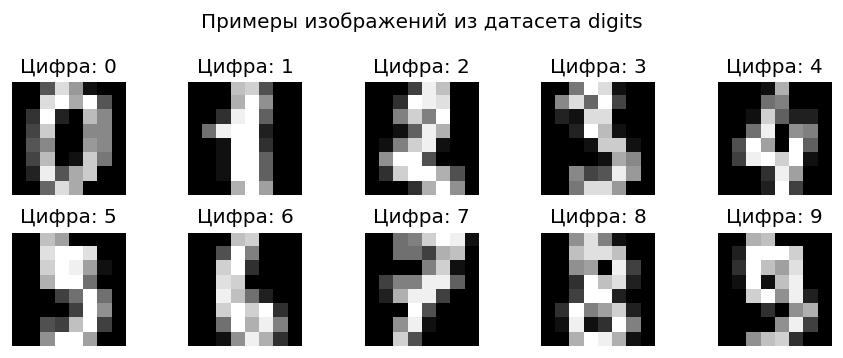

In [3]:
# Визуализируем несколько примеров изображений цифр
n_rows, n_cols = 2, 5
plt.figure(figsize=(1.5 * n_cols, 1.5 * n_rows))
for i in range(n_rows * n_cols):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    ax.imshow(X_digits[i].reshape(8, 8), interpolation='nearest', cmap='gray')
    ax.set_title(f'Цифра: {y_digits[i]}')
    ax.axis('off')
plt.suptitle('Примеры изображений из датасета digits')
plt.tight_layout()
plt.show()

### 1.2. Датасет `swiss roll`

`swiss roll` — искусственный датасет: двумерная поверхность (лента), свернутая в трёхмерном пространстве. Он удобен для демонстрации возможностей нелинейных методов понижения размерности.

In [4]:
X_swiss, t_swiss = make_swiss_roll(n_samples=1000, noise=0.05, random_state=RANDOM_STATE)

print('Форма swiss roll:', X_swiss.shape)

Форма swiss roll: (1000, 3)


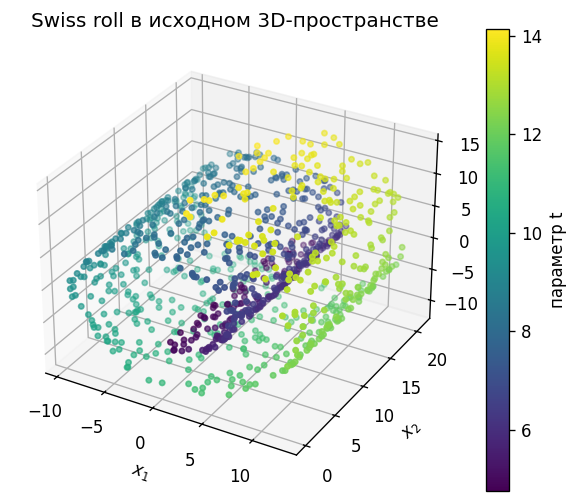

In [5]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=t_swiss, cmap='viridis', s=10)
ax.set_title('Swiss roll в исходном 3D-пространстве')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$')
fig.colorbar(p, ax=ax, label='параметр t')
plt.show()

## 2. Интуиция UMAP

UMAP основан на идее, что данные лежат на (или около) некоторого **многообразия низкой размерности**, встроенного в пространство высокой размерности. Задача метода — построить низкоразмерное вложение, которое сохраняет **локальную топологию** этого многообразия: кто с кем соседствует и как связаны точки.

Высокоуровневая схема:

1. В исходном пространстве строится **граф ближайших соседей** (обычно kNN-граф).
2. На рёбрах графа задаётся **"нечёткая" (fuzzy) мера связи** между точками (значения в $[0, 1]$),
   что можно рассматривать как *fuzzy simplicial complex*.
3. В целевом низкоразмерном пространстве строится аналогичный fuzzy-граф.
4. Вложение оптимизируется так, чтобы эти два fuzzy-графа были как можно более похожими (минимизация
   определённой кросс-энтропийной функции потерь).

UMAP, как и t-SNE, фокусируется на сохранении **локальной структуры**, но реализует другую математику и оптимизацию:
он быстрее, лучше масштабируется и умеет применять уже обученное отображение к новым данным (`transform`).

### 2.1. Граф ближайших соседей

На первом шаге UMAP строит kNN-граф по евклидовому (или другому выбранному) расстоянию между точками. Для каждой точки $x_i$ ищутся $k$ ближайших соседей (параметр `n_neighbors`). Этот параметр определяет,
на каком масштабе мы считаем структуру локальной:

- малые `n_neighbors` — сильный акцент на очень локальных структурах, множество мелких кластеров;
- большие `n_neighbors` — более сглаженное представление, больше внимания к глобальной структуре.

Затем на рёбрах графа вычисляются веса, соответствующие степени связи ("насколько точка-сосед действительно близка"). Это задаёт **нечёткую топологическую структуру** данных.

### 2.2. Fuzzy-граф в низкоразмерном пространстве и функция потерь

В целевом пространстве (обычно двумерном) UMAP располагает точки $y_1, \dots, y_N$ и строит по ним аналогичный fuzzy-граф соседства. Затем минимизируется функция потерь, представляющая собой **кросс-энтропию** между исходным и низкоразмерным fuzzy-графами. Интуитивно:

- пары точек, которые были сильно связаны (высокий вес) в исходном пространстве, penalизируются, если в низкомерном пространстве они оказываются далеко друг от друга (стремятся "притянуться");
- пары, которые почти не были связаны, могут располагаться свободнее, но есть слабое "отталкивание", чтобы избежать скучивания всех точек.

Таким образом, UMAP старается сохранить **локальную топологию** (кто является соседом кого и с какой силой), а не глобальные евклидовы расстояния.

### 2.3. Основные гиперпараметры UMAP

Важнейшие параметры UMAP:

- `n_neighbors` — число ближайших соседей при построении графа. Определяет баланс локальная/глобальная структура.
- `min_dist` — минимальное допустимое расстояние между точками в низкоразмерном пространстве. По сути, контролирует
  **компактность кластеров**:
  - малые значения (`min_dist \approx 0.0`) — кластеры будут плотными, точки "слипаются";
  - большие значения (`min_dist` ближе к 1) — кластеры размываются, занимаются большую площадь.
- `n_components` — размерность целевого пространства (2 или 3 для визуализации, иногда больше для задач ML).
- `metric` — метрика расстояний в исходном пространстве (по умолчанию `euclidean`).
- `random_state` — для воспроизводимости.

Важно: UMAP, в отличие от t-SNE, реализован как трансформер:

- `fit(X)` — обучает модель и строит embedding;
- `transform(X_new)` — даёт embedding для новых точек в тех же координатах.

## 3. UMAP на датасете рукописных цифр `digits`

Начнём с визуализации `digits` с помощью UMAP. Как и в случае t-SNE, полезно сначала привести признаки к сопоставимому масштабу и, при необходимости, сделать предварительное линейное понижение размерности с PCA.

Здесь мы:

1. Стандартизируем признаки (`StandardScaler`).
2. Сожмём данные PCA до 50 компонент (как и для t-SNE) — это уменьшит шум и ускорит UMAP.
3. Построим 2D-вложение UMAP с базовыми параметрами.

In [6]:
# Стандартизируем признаки
scaler_digits = StandardScaler()
X_digits_scaled = scaler_digits.fit_transform(X_digits)

# Линейное понижение размерности до 50 с помощью PCA
pca_50 = PCA(n_components=50, random_state=RANDOM_STATE)
X_digits_pca50 = pca_50.fit_transform(X_digits_scaled)

print('Форма после PCA до 50 компонент:', X_digits_pca50.shape)

Форма после PCA до 50 компонент: (1797, 50)


### 3.1. Базовое встроение UMAP (2D)

Используем следующие параметры:

- `n_neighbors=15` — умеренный акцент на локальной структуре;
- `min_dist=0.1` — кластеры будут относительно компактными, но не полностью "слипшимися";
- `n_components=2` — двумерная визуализация.


In [7]:
umap_2d = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='euclidean',
    random_state=RANDOM_STATE
)

X_digits_umap_2d = umap_2d.fit_transform(X_digits_pca50)
print('Форма после UMAP:', X_digits_umap_2d.shape)

C:\work\PISH\data_analysis_lectures\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Форма после UMAP: (1797, 2)


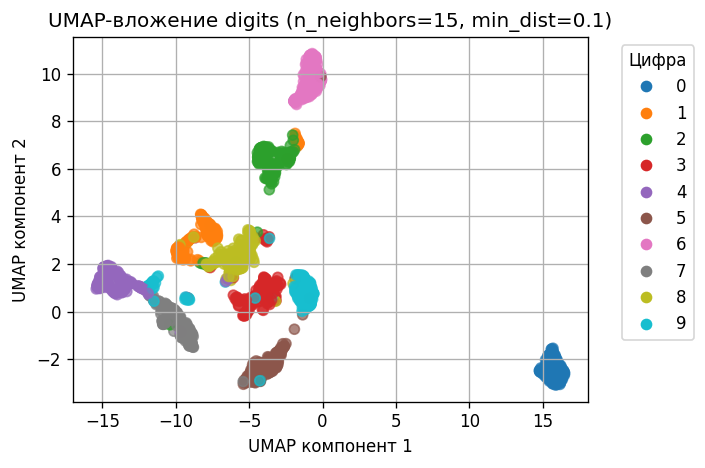

In [8]:
plt.figure()
scatter = plt.scatter(
    X_digits_umap_2d[:, 0],
    X_digits_umap_2d[:, 1],
    c=y_digits,
    alpha=0.7,
    cmap='tab10'
)
plt.xlabel('UMAP компонент 1')
plt.ylabel('UMAP компонент 2')
plt.title('UMAP-вложение digits (n_neighbors=15, min_dist=0.1)')
plt.grid(True)

# Легенда по классам
classes = np.unique(y_digits)
handles = []
for cls in classes:
    color = scatter.cmap(scatter.norm(cls))
    handle = plt.Line2D(
        [], [], marker='o', linestyle='',
        color=color, label=str(cls)
    )
    handles.append(handle)

plt.legend(handles=handles, title='Цифра', bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()

Обычно UMAP для `digits` даёт хорошо разделённые кластеры по цифрам, часто более чётко, чем PCA, и несколько стабильнее по глобальной структуре, чем t-SNE. При этом относительные расстояния между кластерами по-прежнему нельзя интерпретировать как точные метрические расстояния в исходном пространстве.

### 3.2. Влияние `n_neighbors`

Посмотрим, как меняется визуализация при разных значениях `n_neighbors`. Попробуем, например, 5 и 50.

Ожидания:

- `n_neighbors=5` — акцент на очень локальной структуре, много мелких деталей, возможно более фрагментированные кластеры.
- `n_neighbors=50` — более глобальный взгляд на данные, кластеры могут быть более крупными и сглаженными.

C:\work\PISH\data_analysis_lectures\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\work\PISH\data_analysis_lectures\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


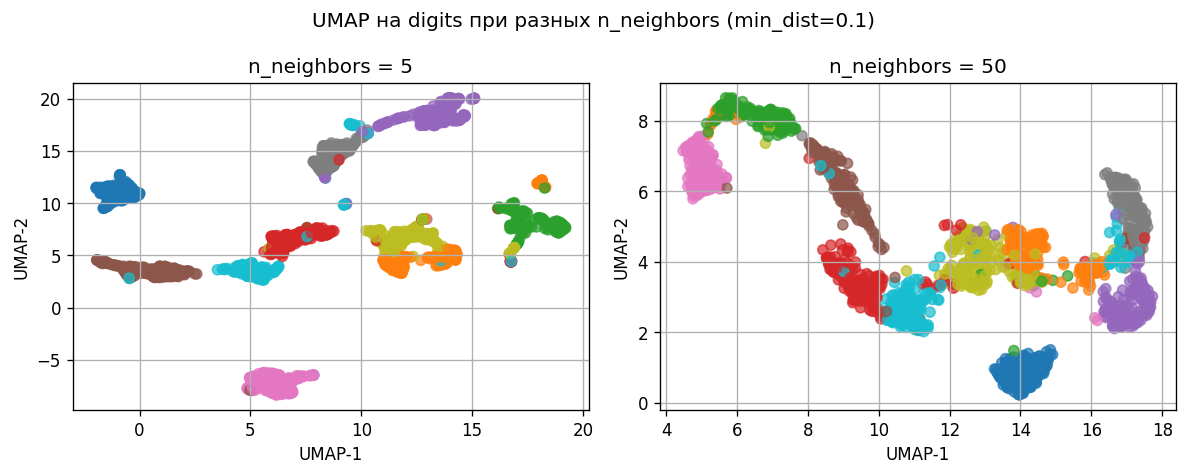

In [9]:
neighbors_list = [5, 50]
embeddings_neighbors = {}

for n_nb in neighbors_list:
    umap_model = umap.UMAP(
        n_neighbors=n_nb,
        min_dist=0.1,
        n_components=2,
        metric='euclidean',
        random_state=RANDOM_STATE
    )
    X_emb = umap_model.fit_transform(X_digits_pca50)
    embeddings_neighbors[n_nb] = X_emb

fig, axes = plt.subplots(1, len(neighbors_list), figsize=(5 * len(neighbors_list), 4))

for ax, n_nb in zip(axes, neighbors_list):
    X_emb = embeddings_neighbors[n_nb]
    scatter = ax.scatter(
        X_emb[:, 0], X_emb[:, 1], c=y_digits, alpha=0.7, cmap='tab10'
    )
    ax.set_title(f'n_neighbors = {n_nb}')
    ax.set_xlabel('UMAP-1')
    ax.set_ylabel('UMAP-2')
    ax.grid(True)

plt.suptitle('UMAP на digits при разных n_neighbors (min_dist=0.1)')
plt.tight_layout()
plt.show()

- При малом `n_neighbors` видны более мелкие локальные структуры, иногда внутри одного класса появляются под-кластеры.
- При большом `n_neighbors` картинка становится более сглаженной, кластеры могут слегка "сливаться".
- Полезно примерять несколько значений `n_neighbors` и смотреть, какая визуализация лучше отражает знания о данных.

### 3.3. Влияние `min_dist`

Теперь зафиксируем `n_neighbors=15` и посмотрим, как параметр `min_dist` влияет на компактность кластеров. Попробуем `min_dist = 0.0`, `0.3` и `0.8`.

Интерпретация:

- `min_dist \approx 0.0` — модель разрешает точкам сильно "слипаться"; кластеры плотные.
- более высокие `min_dist` заставляют точки "раздвигаться", кластеры растягиваются и занимают большую площадь.

C:\work\PISH\data_analysis_lectures\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\work\PISH\data_analysis_lectures\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\work\PISH\data_analysis_lectures\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


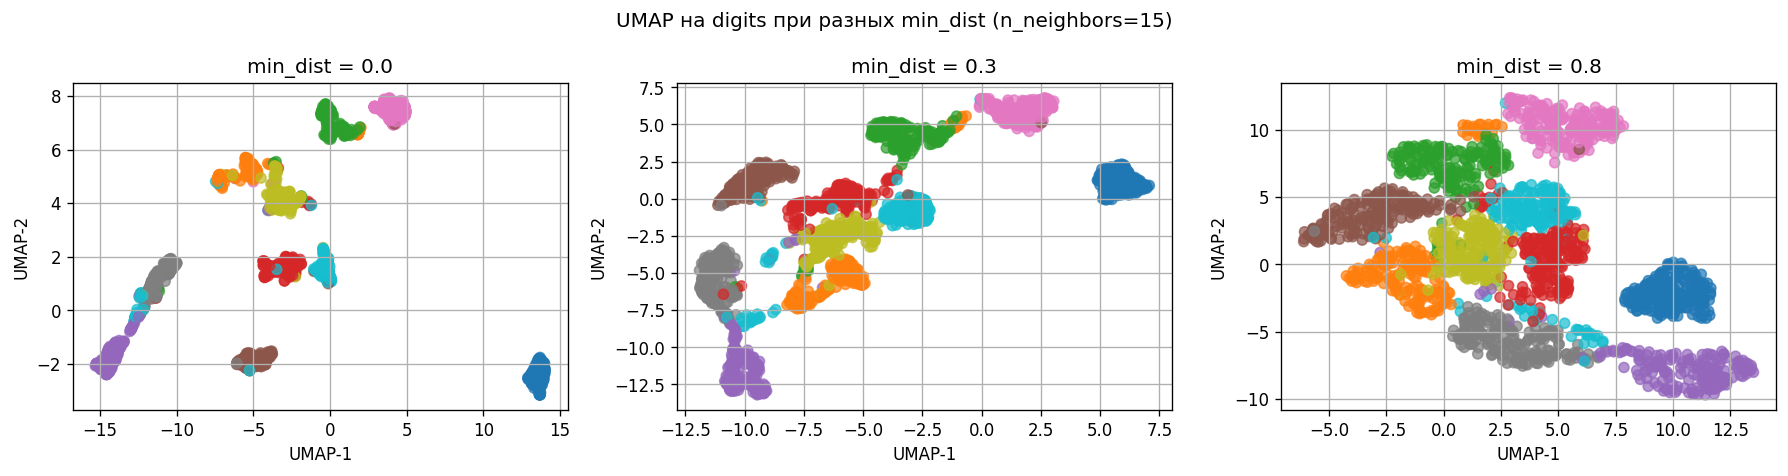

In [10]:
min_dist_list = [0.0, 0.3, 0.8]
embeddings_min_dist = {}

for md in min_dist_list:
    umap_model = umap.UMAP(
        n_neighbors=15,
        min_dist=md,
        n_components=2,
        metric='euclidean',
        random_state=RANDOM_STATE
    )
    X_emb = umap_model.fit_transform(X_digits_pca50)
    embeddings_min_dist[md] = X_emb

fig, axes = plt.subplots(1, len(min_dist_list), figsize=(5 * len(min_dist_list), 4))

for ax, md in zip(axes, min_dist_list):
    X_emb = embeddings_min_dist[md]
    scatter = ax.scatter(
        X_emb[:, 0], X_emb[:, 1], c=y_digits, alpha=0.7, cmap='tab10'
    )
    ax.set_title(f'min_dist = {md}')
    ax.set_xlabel('UMAP-1')
    ax.set_ylabel('UMAP-2')
    ax.grid(True)

plt.suptitle('UMAP на digits при разных min_dist (n_neighbors=15)')
plt.tight_layout()
plt.show()

На этих картинках можно увидеть, что при малом `min_dist` классы собираются в компактные "комки"; при увеличении `min_dist` кластеры становятся более распластанными и могут частично перекрываться.

Выбор `min_dist` зависит от задачи: для идентификации чётких кластеров удобнее малые значения, для плавных многообразий и иллюстрации непрерывных переходов (например, по времени или параметру) — более крупные.

## 4. Сравнение PCA и UMAP на `swiss roll`

Теперь сравним линейное вложение PCA и нелинейное UMAP на классическом примере `swiss roll`.

### 4.1. PCA до 2D

Сначала применим PCA до двух компонент.

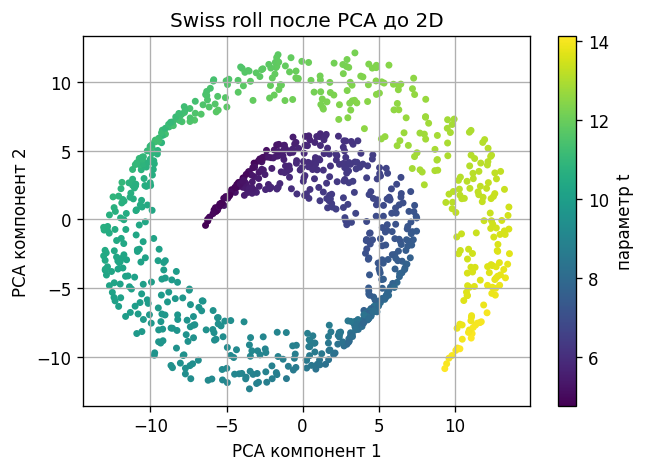

In [11]:
pca_swiss = PCA(n_components=2, random_state=RANDOM_STATE)
X_swiss_pca2 = pca_swiss.fit_transform(X_swiss)

plt.figure()
plt.scatter(X_swiss_pca2[:, 0], X_swiss_pca2[:, 1], c=t_swiss, cmap='viridis', s=10)
plt.xlabel('PCA компонент 1')
plt.ylabel('PCA компонент 2')
plt.title('Swiss roll после PCA до 2D')
plt.colorbar(label='параметр t')
plt.grid(True)
plt.show()

Поскольку `swiss roll` — двумерная поверхность в 3D, PCA даёт неплохую картинку: мы видим спираль, цвет (параметр $t$) меняется относительно плавно. Однако свиток остаётся **закрученным**, и геодезические расстояния по поверхности искажаются: точки, которые по истинному многообразию далеко друг от друга, могут оказаться ближайшими после линейной проекции.

### 4.2. UMAP до 2D

Теперь применим UMAP напрямую к трёхмерным данным.

C:\work\PISH\data_analysis_lectures\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


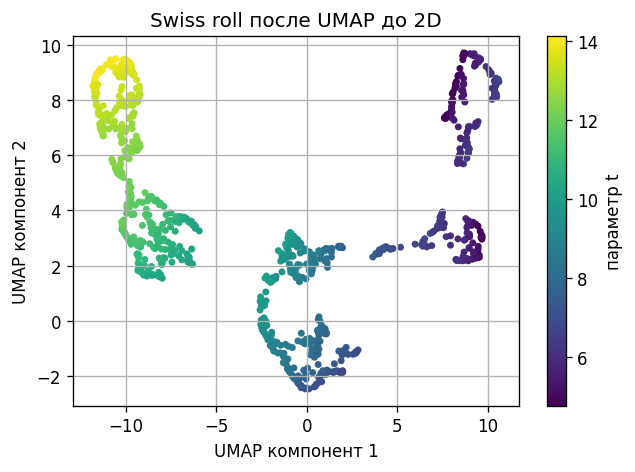

In [12]:
umap_swiss = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='euclidean',
    random_state=RANDOM_STATE
)

X_swiss_umap2 = umap_swiss.fit_transform(X_swiss)

plt.figure()
plt.scatter(X_swiss_umap2[:, 0], X_swiss_umap2[:, 1], c=t_swiss, cmap='viridis', s=10)
plt.xlabel('UMAP компонент 1')
plt.ylabel('UMAP компонент 2')
plt.title('Swiss roll после UMAP до 2D')
plt.colorbar(label='параметр t')
plt.grid(True)
plt.show()

UMAP стремится сохранить локальные соседства вдоль многообразия: точки с близкими значениями $t$ оказываются рядом, а сама лента часто разворачивается в более протяжённую структуру, где цвет меняется более монотонно. При этом глобальная форма (изгибы, расстояния между частями ленты) остаётся модель-зависимой — важно именно то, что локальная структура многообразия сохраняется лучше, чем при чисто линейной проекции.

## 5. Практические замечания и сравнение с t-SNE

### 5.1. Когда использовать UMAP

UMAP особенно полезен, когда нужно:

- визуализировать высокоразмерные данные в 2D/3D;
- исследовать скрытую структуру данных, кластеры, многообразия;
- иметь возможность **применять embedding к новым объектам** через `transform`.

### 5.2. UMAP vs t-SNE (качественно)

- Оба метода фокусируются на сохранении **локальной структуры** и часто дают похожие по качеству визуализации.
- UMAP обычно:
  - **быстрее** и лучше масштабируется на большие выборки;
  - имеет удобный интерфейс `fit`/`transform` для новых данных;
  - позволяет более тонко управлять формой кластеров через `min_dist` и `n_neighbors`.
- t-SNE, в классическом виде:
  - не предоставляет `transform` для новых точек (в `sklearn`);
  - медленнее при больших $N$;
  - иногда даёт более "разлетающиеся" кластеры, но при хорошей настройке параметров тоже хорошо работает.

### 5.3. Ограничения UMAP

- Как и t-SNE, UMAP **не сохраняет глобальные расстояния**: нельзя интерпретировать расстояния между кластерами как реальные метрики в исходном пространстве.
- Результат зависит от гиперпараметров (`n_neighbors`, `min_dist`, `metric`) и случайной инициализации.
- UMAP основан на предположении о наличии многообразия низкой размерности; если данные этого предположения не удовлетворяют, визуализация может вводить в заблуждение.

В целом UMAP — мощный инструмент для визуального исследования данных и хороший компаньон к PCA и t-SNE: их полезно рассматривать вместе и сравнивать получающиеся структуры.